<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 *Logistic Regression*

# Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

%matplotlib inline

#  Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = 'C:/Users/user/Documents/IOD_data_MAIN/DATA/titanic.csv'
titanic = pd.read_csv(titanic_csv)

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
## Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

# EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# ANSWER
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
embarked_mode = str(titanic['Embarked'].mode())
titanic.Embarked.fillna(embarked_mode, inplace=True, axis =0)


In [5]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
def bar_charts(df, feature): #look through this parament to see groupby example.
    '''
    Inputs:
    df: Dataset
    feature: Name of Feature to Check With Survived
    '''
    _agg = {
        'PassengerId': 'count' #count the total passenger
    }
    _groupby = ['Survived', feature] #

    df_feature = df.groupby(by=_groupby).agg(_agg) #_agg is private variable and this is not calling a hidden library 
    
    ax = df_feature.unstack().plot(kind='bar', figsize=(15,6))
    plt.legend(list(df_feature.index.levels[1].unique()))
    plt.xlabel('Survived')
    plt.xticks(np.arange(2), ('No', 'Yes'))
    plt.show();

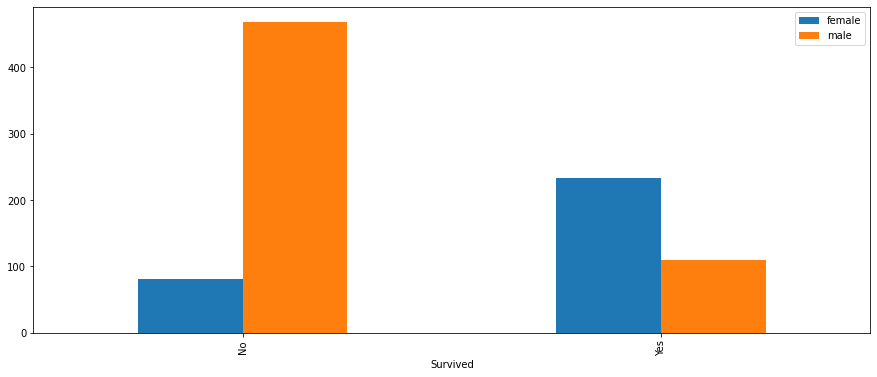

In [8]:
bar_charts(titanic, 'Sex')

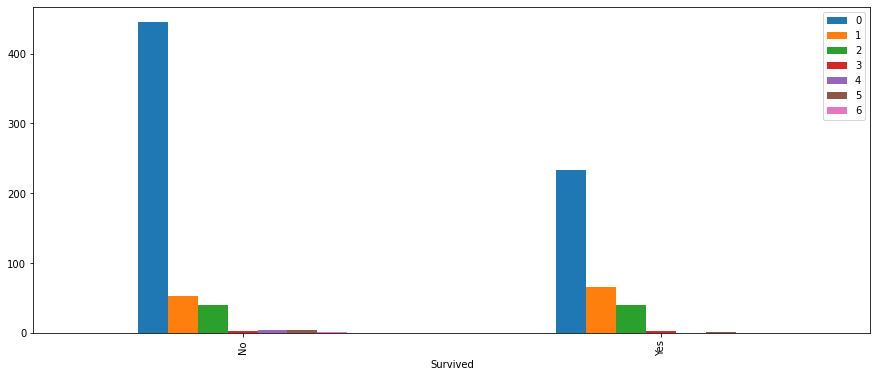

In [9]:
bar_charts(titanic, 'Parch')

# Numerical Predictors Only

## Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [10]:
# ANSWER
X = titanic[['Pclass', 'Parch']]
y = titanic['Survived']



In [11]:
y.shape

(891,)

In [12]:
X.shape

(891, 2)

In [13]:
#titanic_pclass = titanic[['Pclass', 'Survived']].groupby(['Pclass']).mean
#print(titanic_pclass())

In [14]:
#titanic_parch = titanic[['Parch', 'Survived']].groupby(['Parch']).mean
#print(titanic_parch())

## Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [15]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [16]:
y_test.value_counts()

0    106
1     73
Name: Survived, dtype: int64

In [17]:
X_train.value_counts()

Pclass  Parch
3       0        303
1       0        130
2       0        108
3       1         44
        2         32
1       1         28
2       1         28
1       2         15
2       2         13
3       3          3
        4          3
        5          2
1       4          1
2       3          1
3       6          1
dtype: int64

## Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [18]:
# ANSWER
# Create Model
logres = LogisticRegression()


Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [19]:
# ANSWER
# Fit Model
logres.fit(X_train,y_train)


LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [20]:
# ANSWER
logres.coef_

array([[-0.90824213,  0.33432156]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [21]:
# ANSWER
logres.intercept_


array([1.40820621])

We can create tuples of the predictor names and coefficients like this:

In [22]:
# ANSWER
feature_cols = titanic[['Pclass', 'Parch']]
print(set(zip(feature_cols, logres.coef_[0])))

{('Pclass', -0.9082421341469834), ('Parch', 0.3343215551477792)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [23]:
for col in zip(X_train.columns,logres.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.908242
Parch       +0.334322


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [24]:
# ANSWER
#logres.score(X_test,y_test), 1 - y_train.sum() /len(y_train)


In [25]:
from sklearn.metrics import accuracy_score
y_pred= logres.predict(X_test)
accuracy_score(y_test,y_pred)

0.6536312849162011

What is the  `accuracy_score` for the test data?

In [26]:
# ANSWER
y_pred_test = logres.predict(X_test)
accuracy_score(y_test,y_pred_test)

0.6536312849162011

What can we say aout this result?

ANSWER
- ...
- ...

## Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [27]:
# ANSWER
titanic['Age'].fillna(titanic['Age'].mean(), inplace = True)

In [28]:
X = titanic[['Pclass', 'Parch','Age']]
y = titanic['Survived']

In [29]:
# Build Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
logres = LogisticRegression()
# Fit Model
logres.fit(X_train,y_train)
print(logres.coef_, logres.intercept_)


[[-1.11363534  0.2508938  -0.03360635]] [2.90796631]


In [30]:
# Score
y_pred= logres.predict(X_train)
accuracy_score(y_train,y_pred)

0.7247191011235955

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [31]:
# ANSWER
y_pred_class = logres.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[88 18]
 [42 31]]


Nb. Here is how `confusion_matrix` arranges its output:

In [32]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

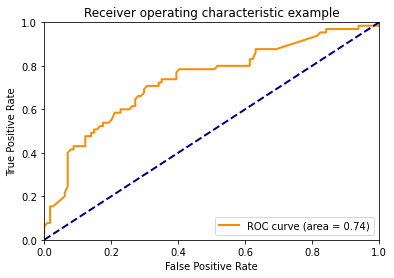

In [48]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logres.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

# Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [34]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_0 S\ndtype: object,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,0,1,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [35]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [36]:
titanic_with_dummies['Age'].value_counts()

29.699118    177
24.000000     30
22.000000     27
18.000000     26
30.000000     25
            ... 
53.000000      1
55.500000      1
0.920000       1
24.500000      1
70.500000      1
Name: Age, Length: 89, dtype: int64

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [37]:
# ANSWER
# Set Feature Both Numerical, Categorical
X_dummies = titanic_with_dummies[['Age','Pclass_1']]
y_dummies = titanic_with_dummies['Survived']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_dummies, test_size=0.20, random_state=1)


In [39]:
logres.fit(X_train,y_train)
print(logres.coef_, logres.intercept_)

[[-0.02952848  1.65394024]] [-0.05230917]


In [40]:
y_pred_dummies= logres.predict(X_train)
accuracy_score(y_train,y_pred_dummies)

0.6910112359550562

Plot the ROC curve for the new model:

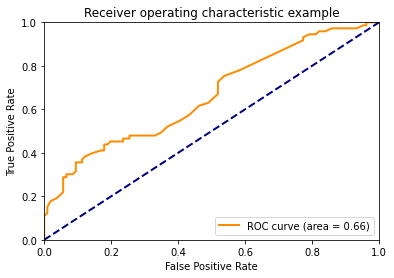

In [41]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logres.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [42]:
# ANSWER
X_dummies = titanic_with_dummies[['Age',"Parch", "Sex_male", "Pclass_1", "Pclass_2"]]
y_dummies = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y_dummies, test_size=0.20, random_state=1)
logres.fit(X_train,y_train)
print(logres.coef_, logres.intercept_)

[[-0.03371216 -0.10282578 -2.54875814  2.22074219  1.22731114]] [1.22973411]


In [43]:
y_pred_dummies= logres.predict(X_train)
accuracy_score(y_train,y_pred_dummies)

0.8019662921348315

# Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [44]:
X = titanic[['Pclass', 'Parch','Age']]
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
logres = LogisticRegression()
# Fit Model
logres.fit(X_train,y_train)
print(logres.coef_, logres.intercept_)

[[-1.05677736  0.13652241 -0.03154861]] [2.82317777]


In [45]:
y_pred= logres.predict(X_train)
accuracy_score(y_train,y_pred)

0.7064606741573034

In [46]:
from sklearn.model_selection import cross_val_score

cross_val_score(logres,X,y, scoring = 'accuracy').mean()

0.6992969681752558

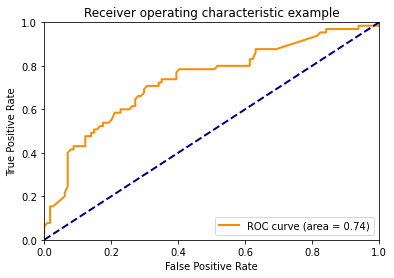

In [47]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logres.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()